# Final: Amazon Product Review Kaggle Competition
# Model 1
## DSE 220: Machine Learning
## Due Date: 11 June 2017
## Orysya Stus

In [72]:
import pandas as pd
import numpy as np
from collections import defaultdict
import gzip
import matplotlib as plt
%pylab inline

from sklearn.cross_validation import StratifiedKFold, cross_val_predict
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


C:\Users\Orysya\Anaconda\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

train_df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

## Data Processing & Feature Engineering

In [3]:
print('The shape of train_df is', train_df.shape)
train_df.head(2)

The shape of train_df is (200000, 12)


,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price
0,0,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",I655355328,U745881038,3.0,"These are cute, but they are a little small. ...",R115160670,"05 20, 2014",Cute,1400544000,"{'outOf': 0, 'nHelpful': 0}",NaN
1,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I241092314,U023577405,4.0,"I love the look of this bra, it is what I want...",R800651687,"02 7, 2013",Beautiful but size runs small,1360195200,"{'outOf': 0, 'nHelpful': 0}",NaN


In [10]:
# Examine the number of null values in the train_df
print(train_df.isnull().sum())
print('\n Column price needs to be dropped since', train_df['price'].isnull().sum()/train_df.shape[0] * 100.0, '% of the data is null.')

categoryID             0
categories             0
itemID                 0
reviewerID             0
rating                 0
reviewText             0
reviewHash             0
reviewTime             0
summary                0
unixReviewTime         0
helpful                0
price             125851
dtype: int64

 Column price needs to be dropped since 62.9255 % of the data is null.


In [66]:
# Determine which items might be too unique for predictive purposes
print('For column itemID, there are ', train_df['itemID'].nunique(), 'unique values for', train_df.shape[0], 'instances.')
print('For column itemID, there are ', train_df['reviewerID'].nunique(), 'unique values for', train_df.shape[0], 'instances.')
print('For column itemID, there are ', train_df['reviewHash'].nunique(), 'unique values for', train_df.shape[0], 'instances.')
print('For column itemID, there are ', train_df['categoryID'].nunique(), 'unique values for', train_df.shape[0], 'instances.')

print('\n All values for reviewHash are unique, thus column reviewHash does not provide any predictive advantage and should be dropped.')

For column itemID, there are  19913 unique values for 200000 instances.
For column itemID, there are  39249 unique values for 200000 instances.
For column itemID, there are  200000 unique values for 200000 instances.
For column itemID, there are  5 unique values for 200000 instances.

 All values for reviewHash are unique, thus column reviewHash does not provide any predictive advantage and should be dropped.


In [4]:
print('The shape of train_df is', test_df.shape)
test_df.head(2)

The shape of train_df is (14000, 12)


,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price
0,0,"[[Sports & Outdoors, Other Sports, Dance, Clot...",I520932398,U816789534,3.0,I ordered according to the size chart but it's...,R157684793,"07 15, 2011",Too small,1310688000,{'outOf': 2},NaN
1,0,"[[Sports & Outdoors, Clothing, Women, Hoodies]...",I969532331,U987148846,4.0,Super thin but really cute and not cheap-looki...,R732719858,"07 17, 2013",Fun hoodie,1374019200,{'outOf': 0},NaN


In [83]:
def data_preprocessing(dataframe):
    """The function breaksdown the helpful colum into outOf & nHelpful. Converts reviewTime to datetime. Removes 
    reviewHash (unique, provides no predictive power). Takes categoryID and turns it into dummy variables then
    deleted categoryID."""
    dummies = pd.get_dummies(dataframe['categoryID']).rename(columns=lambda x: 'categoryID_'+str(x))
    dataframe = pd.concat([dataframe, dummies], axis=1)
    del dataframe['categoryID']
    helpful = pd.DataFrame.from_dict(dict(dataframe['helpful'])).T
    dataframe = pd.concat([dataframe, helpful], axis=1)
    del dataframe['helpful']
    dataframe['reviewTime'] = pd.to_datetime(dataframe['reviewTime'])
    del dataframe['unixReviewTime']
    del dataframe['reviewHash']
    del dataframe['price']
    return dataframe

In [84]:
def get_helpful_rate(dataframe):
    """The function creates the field helpful_rate."""
    dataframe['helpful_rate'] = dataframe['nHelpful']/dataframe['outOf']
    return dataframe

In [85]:
train = data_preprocessing(train_df)
# The helpful_rate (nHelpful/outof) might be a better feature holding more predictive power. Create the value for the training set
train = get_helpful_rate(train)
train.head(2)

,categories,itemID,reviewerID,rating,reviewText,reviewTime,summary,categoryID_0,categoryID_1,categoryID_2,categoryID_3,categoryID_4,nHelpful,outOf,helpful_rate
0,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",I655355328,U745881038,3.0,"These are cute, but they are a little small. ...",2014-05-20,Cute,1,0,0,0,0,0,0,NaN
1,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I241092314,U023577405,4.0,"I love the look of this bra, it is what I want...",2013-02-07,Beautiful but size runs small,1,0,0,0,0,0,0,NaN


In [86]:
test = data_preprocessing(test_df)
test.head(2)

,categories,itemID,reviewerID,rating,reviewText,reviewTime,summary,categoryID_0,categoryID_1,categoryID_2,categoryID_3,categoryID_4,outOf
0,"[[Sports & Outdoors, Other Sports, Dance, Clot...",I520932398,U816789534,3.0,I ordered according to the size chart but it's...,2011-07-15,Too small,1,0,0,0,0,2
1,"[[Sports & Outdoors, Clothing, Women, Hoodies]...",I969532331,U987148846,4.0,Super thin but really cute and not cheap-looki...,2013-07-17,Fun hoodie,1,0,0,0,0,0


In [112]:
from nltk.corpus import stopwords
import string
from itertools import chain

def reviewText_listed(row):
    all_words = row.split()
    all_words = [w.lower() for w in all_words]
#     subset_list = [''.join(c for c in s if c not in string.punctuation) for s in all_words]
#     subset_list = [w for w in subset_list if w != '']
#     subset_list = [word for word in subset_list if word not in stopwords.words('english')]
#     return all_words, len(all_words), subset_list, len(subset_list)
    return len(all_words)

def reviewText_processing(dataframe):
    """The function returns 4 dictionaries (all review text words, all review text
    words count, content (non-punctuation & non-stopwords) text words, content text
    words count, & a vocabulary list of the content words)."""
#     review_allText = {}
    review_allText_count = {}
#     review_keyText = {}
#     review_keyText_count = {}
#     vocabulary = []
    count = 0
#     if subset_on == 'True':
#         dataframe = dataframe[dataframe['outOf'] != 0]
#     else:
#         dataframe = dataframe
    reviewText = list(dataframe['reviewText'])
    for text in reviewText:
#         all_, all_count, subset_, subset_count = reviewText_listed(text)
        all_count = reviewText_listed(text)
#         review_allText[count] = all_
        review_allText_count[count] = all_count
#         review_keyText[count] = subset_
#         review_keyText_count[count] = subset_count
#         vocabulary.append(subset_)
        count += 1
#     vocabulary = set(list(chain.from_iterable(vocabulary)))
    return dataframe, review_allText_count
#     return dataframe, review_allText, review_allText_count, review_keyText, review_keyText_count, vocabulary

In [113]:
train, train_alltext_count = reviewText_processing(train)
train['alltext_count'] = list(train_alltext_count.values())
# train['keytext_count'] = list(train_keytext_count.values())
# train['key_vs_all_ratio'] =train['keytext_count']/train['alltext_count']

test, test_alltext_count = reviewText_processing(test)
test['alltext_count'] = list(test_alltext_count.values())
# test['keytext_count'] = list(test_keytext_count.values())
# test['key_vs_all_ratio'] = test['keytext_count']/test['alltext_count']

## Data Exploration

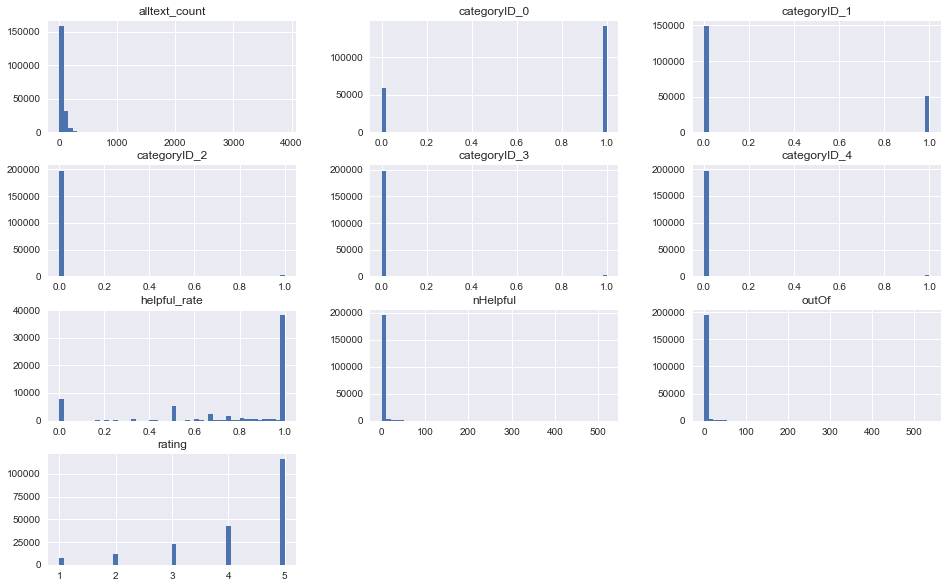

In [121]:
train.hist(bins = 50, figsize=(16,10));

In [116]:
train.describe()

,rating,categoryID_0,categoryID_1,categoryID_2,categoryID_3,categoryID_4,nHelpful,outOf,helpful_rate,alltext_count
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,63016.000000,200000.000000
mean,4.233590,0.707050,0.256990,0.011730,0.009540,0.014690,1.115355,1.309145,0.782856,59.164485
std,1.107719,0.455117,0.436975,0.107668,0.097206,0.120309,5.863531,6.307235,0.344661,59.263191
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,26.000000
50%,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,41.000000
75%,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,69.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,520.000000,537.000000,1.000000,3882.000000


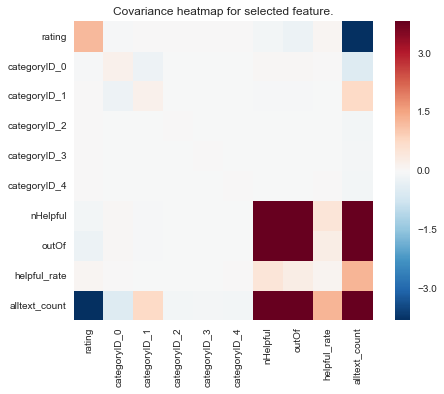

In [117]:
import seaborn as sns
mat = train.cov() # to get a heatmap of the covariance matrix
a = sns.heatmap(mat, vmax=1, square = True)
a.set_title('Covariance heatmap for selected feature.')

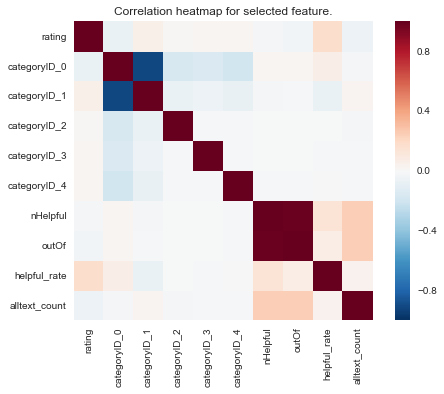

In [118]:
mat = train.corr() # to get a heatmap of the correlation matrix
a = sns.heatmap(mat, vmax=1, square = True)
a.set_title('Correlation heatmap for selected feature.')

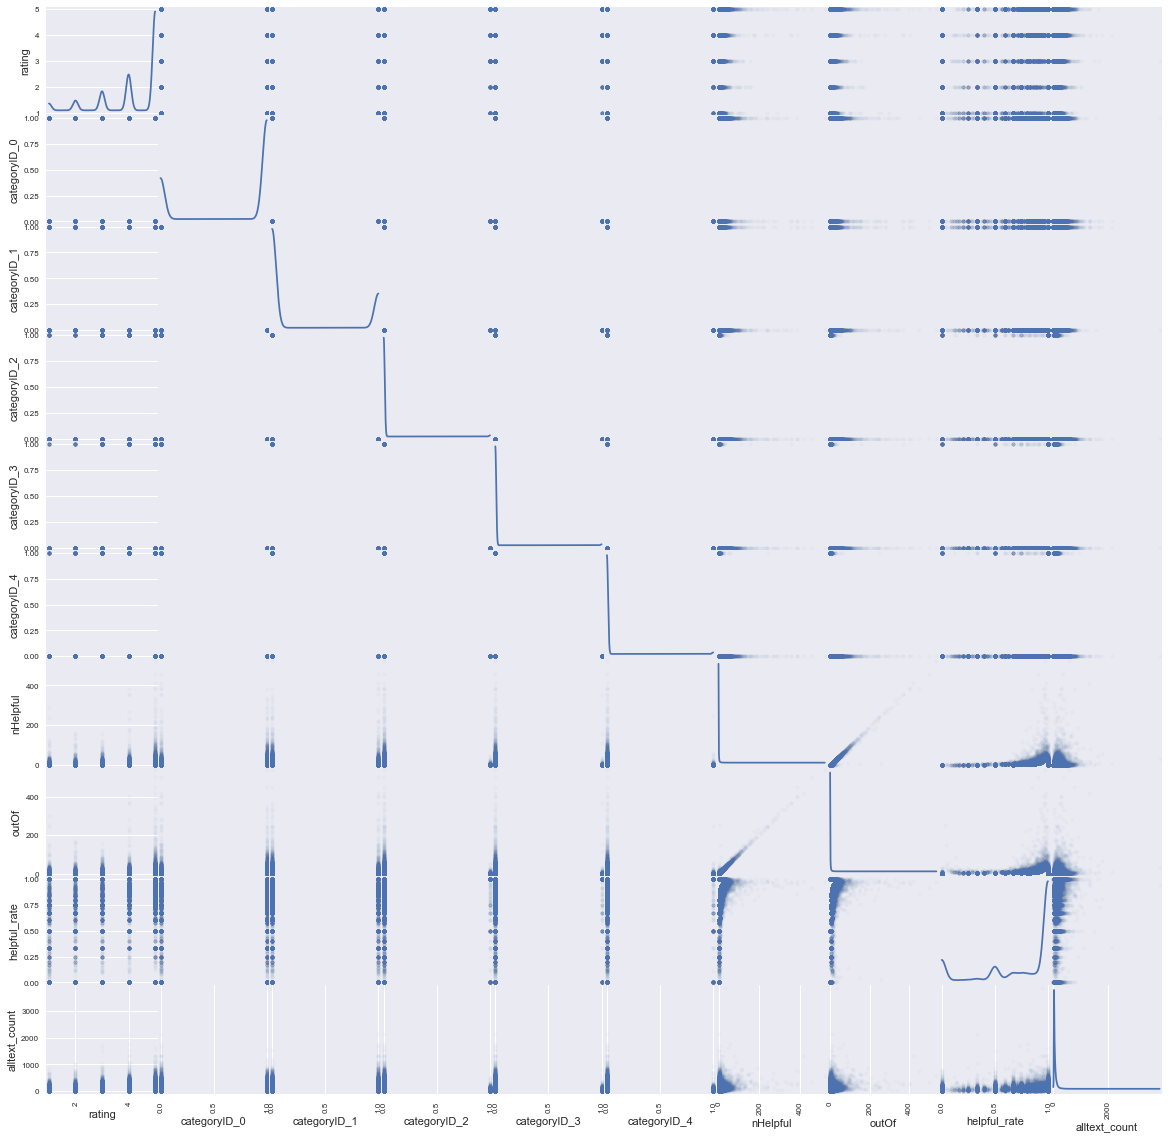

In [122]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(train, alpha=0.03, figsize=(20, 20), diagonal='kde');

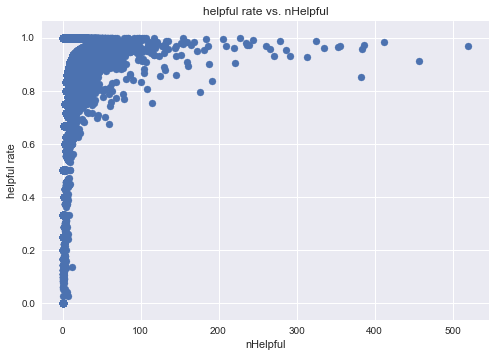

In [127]:
plt.scatter(train['nHelpful'], train['helpful_rate']);
plt.title('helpful rate vs. nHelpful');
plt.xlabel('nHelpful');
plt.ylabel('helpful rate');

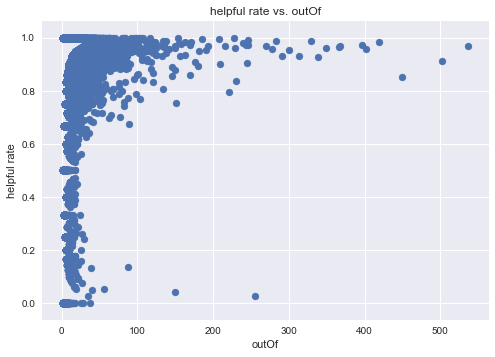

In [128]:
plt.scatter(train['outOf'], train['helpful_rate']);
plt.title('helpful rate vs. outOf');
plt.xlabel('outOf');
plt.ylabel('helpful rate');

## Modeling

In [130]:
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
from sklearn.cross_validation import cross_val_score, cross_val_predict, StratifiedKFold 
from sklearn.metrics import mean_absolute_error

In [163]:
from sklearn.model_selection import train_test_split

def data_to_model(dataframe, test_train, features, class_attribute, random_state):
    """The function prepares the train & test dataframes for modeling."""
    if test_train == 'train':
        X_train = pd.DataFrame(dataframe, columns=features)
        y_train = pd.DataFrame(dataframe[class_attribute])
        X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
        return X_train, y_train, X_train1, y_train1, X_valid, y_valid
    elif test_train == 'test':
        X_test = pd.DataFrame(dataframe, columns=features)
        return X_test
    else:
        pass

In [346]:
import warnings
warnings.filterwarnings('ignore')

mae = []
mae_rounding = []
columns = ['rating', 'outOf', 'categoryID_0', 'categoryID_1', 'categoryID_2', 'categoryID_3', 'categoryID_4']
iteration = 0
for i in range(10):
    print('\n ****************** For round', iteration, 'validation set. ****************** ')
    #For outOf ==0, always remove 0 therefore    
    X_train, y_train, X_train1, y_train1, X_valid, y_valid = data_to_model(train, 'train', columns, ['helpful_rate', 'nHelpful'], i)
    
    # For outOf == 1 binary classifier: Gradient Boosting Classifier
    one_X_train = X_train1[X_train1['outOf'] == 1 ]
    one_y_train = np.array(y_train1['helpful_rate'][X_train1['outOf'] == 1])
    one_kf = StratifiedKFold(one_y_train, n_folds=10, shuffle=True, random_state=0)
    gridparams = dict(learning_rate=[0.01, 0.1],loss=['deviance','exponential'])
    params = {'n_estimators': 100, 'max_depth': 4}
    gbclf = GridSearchCV(ensemble.GradientBoostingClassifier(**params), gridparams, cv=one_kf, scoring='mean_absolute_error',n_jobs=-1)
    gbclf = GridSearchCV(ensemble.GradientBoostingClassifier(**params), gridparams, scoring='mean_absolute_error',n_jobs=-1)
    gbclf.fit(one_X_train, one_y_train)
    print("Best model:")
    print(gbclf.best_estimator_)
    print("")
    
    # Rest of data regressor: Gradient Boosting Regressor
    rest_X_train = X_train1[(X_train1['outOf'] != 1) & (X_train1['outOf'] != 0)]
    rest_y_train = np.array(y_train1['helpful_rate'][(X_train1['outOf'] != 1) & (X_train1['outOf'] != 0)])
    rest_kf = StratifiedKFold(rest_y_train, n_folds=10, shuffle=True, random_state=0)
    gridparams = dict(learning_rate=[0.01, 0.1], loss=['ls', 'lad'])
    params = {'n_estimators': 100, 'max_depth': 4}
    gbreg = GridSearchCV(ensemble.GradientBoostingRegressor(**params), gridparams, scoring='mean_absolute_error', n_jobs=-1)
    gbreg = GridSearchCV(ensemble.GradientBoostingRegressor(**params), gridparams, cv=rest_kf, scoring='mean_absolute_error', n_jobs=-1)
    gbreg.fit(rest_X_train, rest_y_train)
    print("Best model:")
    print(gbreg.best_estimator_)
    print("")

    # Predicting on the validation set:
    y_pred = {}
    X_valid1 = X_valid.reset_index(drop = True)
    for j in range(len(X_valid1)):
        if X_valid1['outOf'][j] == 0:
            y_pred[j] = 0
        elif X_valid1['outOf'][j] == 1:
            y_pred[j] = (gbclf.predict(np.array(X_valid1.iloc[j]))[0])*(X_valid1['outOf'][j])
        else:
            y_pred[j] = (gbreg.predict(np.array(X_valid1.iloc[j]))[0])*(X_valid1['outOf'][j])
    
    print("Without rounding, mean absolute error: %0.3f" % mean_absolute_error(list(y_valid['nHelpful']), list(y_pred.values())))
    mae.append(mean_absolute_error(list(y_valid['nHelpful']), list(y_pred.values())))
    print("With rounding, mean absolute error: %0.3f" % mean_absolute_error(list(y_valid['nHelpful']), np.round(list(y_pred.values()), 0)))
    mae_rounding.append(mean_absolute_error(list(y_valid['nHelpful']), np.round(list(y_pred.values()), 0)))
    iteration += 1
    
print('\n Using the following features: ', columns)    
print('Without rounding, "mean" mae: %0.3f' % mean(mae))
print('With rounding, "mean" mae: %0.3f' % mean(mae_rounding))


 ****************** For round 0 validation set. ****************** 
Best model:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Best model:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Without rounding, mean absolute error: 0.16

Without rounding, mean absolute error: 0.166
With rounding, mean absolute error: 0.165

 ****************** For round 8 validation set. ****************** 
Best model:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Best model:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0,

Predict on test data set: 
-    Method: if X_train1['outOf'] == 0 then y_pred == 0, elif X_train1['outOf'] == 1 then perform GradientBoostingClassifier, else perform GradientBoostingRegresor
-    Using the following features:  ['rating', 'outOf', 'categoryID_0', 'categoryID_1', 'categoryID_2', 'categoryID_3', 'categoryID_4']
-    Without rounding, "mean" mae: 0.169, 
-    With rounding, "mean" mae: 0.168


In [347]:
### Predict on test data set: Without rounding, "mean" mae: 0.169, With rounding, "mean" mae: 0.168
warnings.filterwarnings('ignore')

one_X_train = X_train[X_train['outOf'] == 1 ]
one_y_train = np.array(y_train['helpful_rate'][X_train['outOf'] == 1])
gbclf = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
gbclf.fit(one_X_train, one_y_train)

rest_X_train = X_train[(X_train['outOf'] != 1) & (X_train['outOf'] != 0)]
rest_y_train = np.array(y_train['helpful_rate'][(X_train['outOf'] != 1) & (X_train['outOf'] != 0)])
gref = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
gbreg.fit(rest_X_train, rest_y_train)

X_test = pd.DataFrame(test, columns=columns)
y_pred = {}
for j in range(len(X_test)):
    if X_test['outOf'][j] == 0:
        y_pred[j] = 0
    elif X_test['outOf'][j] == 1:
        y_pred[j] = (gbclf.predict(np.array(X_test.iloc[j]))[0])*(X_test['outOf'][j])
    else:
        y_pred[j] = (gbreg.predict(np.array(X_test.iloc[j]))[0])*(X_test['outOf'][j])

In [353]:
def predictions_exported(test, y_pred, rounding_on, output_file):
    predictions = []
    test_user_id = list(test['reviewerID'])
    test_item_id = list(test['itemID'])
    outOf = list(test['outOf'])
    
    if rounding_on == True:
        predictions = np.round(list(y_pred.values()), 0)
    else:
        predictions = list(y_pred.values())

    output = open(output_file, 'w')
    output.write('userID-itemID-outOf,prediction\n')
    for i in range(len(predictions)):
        user = test_user_id[i]
        item = test_item_id[i]
        outof = outOf[i]
        prediction = predictions[i]
        output.write(user + '-' + item + '-' + str(outof) + ',' + str(prediction) + '\n')

In [355]:
predictions_exported(test, y_pred, True, 'ensemble_gb_0.168_rounding1_6.10.2017.csv') # 0.16171
predictions_exported(test, y_pred, False, 'ensemble_gb_0.169_norounding1_6.10.2017.csv') # 0.16348